# Machine Learning Engineer Nanodegree
## Capstone Project
Patrick Poon  
May 13, 2018

## I. Definition
_(approx. 1-2 pages)_

### Project Overview

In this section, look to provide a high-level overview of the project in layman’s terms. Questions to ask yourself when writing this section:
- _Has an overview of the project been provided, such as the problem domain, project origin, and related datasets or input data?_
- _Has enough background information been given so that an uninformed reader would understand the problem domain and following problem statement?_
<!--
-->

> Most people...the interaction that they're going to have with a police officer is because [...] they're stopped for speeding.  Or, forgetting to turn their blinker off.[1]
> 
>-- Cheryl Phillips, Journalism Professor at Stanford University

On a typical day in the United States, police officers make more than 50,000 traffic stops.[2]  In recent years, there have been numerous incidents that have made national headlines that involved an officer shooting and, in some cases, killing the driver or an occupant.  Many cite racial biases against Blacks and Hispanics for the disproportionate number of such incidents.  Here are some relevant articles:

- Was the Sandra Bland traffic stop legal -- and fair? (https://www.cnn.com/2015/07/23/opinions/cevallos-sandra-bland-traffic-stop/index.html)
- Philando Castile shooting: Dashcam video shows rapid event (https://www.cnn.com/2017/06/20/us/philando-castile-shooting-dashcam/index.html)

This Capstone project will not attempt to prove or disprove this controversial topic, and will attempt to  avoid making any controversial or provocative statements on either side of the conversation.


### Problem Statement

In this section, you will want to clearly define the problem that you are trying to solve, including the strategy (outline of tasks) you will use to achieve the desired solution. You should also thoroughly discuss what the intended solution will be for this problem. Questions to ask yourself when writing this section:
- _Is the problem statement clearly defined? Will the reader understand what you are expecting to solve?_
- _Have you thoroughly discussed how you will attempt to solve the problem?_
- _Is an anticipated solution clearly defined? Will the reader understand what results you are looking for?_
<!--
-->

Instead, this project aims to create a multi-class classifier that takes various discrete traffic stop situational values to predict the outcome of a traffic stop, specifically in the state of Connecticut (CT).  Given a driver's age, gender, race, traffic stop violation, and the county in which a traffic stop occurs, can we reliably predict whether the traffic stop will result in a verbal/written warning, a ticket, a summons to appear in court, or an arrest?

To accomplish this task, I will parse and process traffic stop data for the state of Connecticut, and feed it into a supervised learning algorithm that I will train and tune to predict these outcomes.  The data comes from the Stanford Open Policing Project (SOPP) at https://openpolicing.stanford.edu/data/. SOPP has collected data for 31 states, but the CT dataset was the cleanest and most consistent.

<!-- 
Direct file link:  https://stacks.stanford.edu/file/druid:py883nd2578/CT-clean.csv.gz
-->

### Metrics
In this section, you will need to clearly define the metrics or calculations you will use to measure performance of a model or result in your project. These calculations and metrics should be justified based on the characteristics of the problem and problem domain. Questions to ask yourself when writing this section:
- _Are the metrics you’ve chosen to measure the performance of your models clearly discussed and defined?_
- _Have you provided reasonable justification for the metrics chosen based on the problem and solution?_


For this project, I will use **accuracy classification score** as my evaluation metric.  According to the sklearn page for the **`accuracy_score`** function[5], in the context of multiclass classification, the function is equivalent to the **`jaccard_similarity_score`** function which calculates the Jaccard index, also known as "Intersection over Union," as illustrated in the following formula:

<center>
![Intersection over Union formula](./images/IoU.svg)
</center>

[TODO: Add reference to sklearn accuracy_score page:  http://scikit-learn.org/stable/modules/generated/sklearn.metrics.accuracy_score.html]
[TODO: Add reference to wiki source:  https://en.wikipedia.org/wiki/Jaccard_index]


## II. Analysis
_(approx. 2-4 pages)_

### Data Exploration & Exploratory Visualization
In this section, you will be expected to analyze the data you are using for the problem. This data can either be in the form of a dataset (or datasets), input data (or input files), or even an environment. The type of data should be thoroughly described and, if possible, have basic statistics and information presented (such as discussion of input features or defining characteristics about the input or environment). Any abnormalities or interesting qualities about the data that may need to be addressed have been identified (such as features that need to be transformed or the possibility of outliers). Questions to ask yourself when writing this section:
- _If a dataset is present for this problem, have you thoroughly discussed certain features about the dataset? Has a data sample been provided to the reader?_
- _If a dataset is present for this problem, are statistics about the dataset calculated and reported? Have any relevant results from this calculation been discussed?_
- _If a dataset is **not** present for this problem, has discussion been made about the input space or input data for your problem?_
- _Are there any Mabnormalities or characteristics about the input space or dataset that need to be addressed? (categorical variables, missing values, outliers, etc.)_

### Exploratory Visualization
In this section, you will need to provide some form of visualization that summarizes or extracts a relevant characteristic or feature about the data. The visualization should adequately support the data being used. Discuss why this visualization was chosen and how it is relevant. Questions to ask yourself when writing this section:
- _Have you visualized a relevant characteristic or feature about the dataset or input data?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

In this section, I will break down and decompose the raw data into its basic elements.  In doing so, I will attempt to gain insights that may guide me at different points in my journey to develop an effective and accurate classifier.  I will start by presenting some sample records, then discuss why certain columns should be dropped, and finally explore characteristics of some columns that may provide predictive power for my classifier.


In [168]:
from datetime import datetime

import humanize
import numpy as np
import pandas as pd
from tabulate import tabulate

%matplotlib inline

In [98]:
df = pd.read_csv('./data/CT-clean.csv', header=0)

D:\AppData\Local\conda\conda\envs\kaggle\lib\site-packages\IPython\core\interactiveshell.py:2717: DtypeWarning: Columns (22) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


The raw data is comprised of 318,669 records with 24 columns over a period of 1 year and 5 months from 2013 to 2015.  Here are a few sample rows with the feature columns broken down into three sections (**Please note**: Different rows have been selected for each section to provide a sense of the complexity involved with the different columns in this dataset):

In [99]:
df.shape

(318669, 24)

In [100]:
df.iloc[:,:8].head()

,id,state,stop_date,stop_time,location_raw,county_name,county_fips,fine_grained_location
0,CT-2013-00001,CT,2013-10-01,00:01,westport,Fairfield County,9001.0,"00000 N I 95 (WESTPORT, T158) X 18 LL"
1,CT-2013-00002,CT,2013-10-01,00:02,mansfield,Tolland County,9013.0,rte 195 storrs
2,CT-2013-00003,CT,2013-10-01,00:07,franklin,New London County,9011.0,Rt 32/whippoorwill
3,CT-2013-00004,CT,2013-10-01,00:10,danbury,Fairfield County,9001.0,I-84
4,CT-2013-00005,CT,2013-10-01,00:10,east hartford,Hartford County,9003.0,"00000 W I 84 (EAST HARTFORD, T043)E.OF XT.56"


<br>

In [101]:
df.iloc[24500:24506,8:16].head()

,police_department,driver_gender,driver_age_raw,driver_age,driver_race_raw,driver_race,violation_raw,violation
24500,State Police,M,39,39.0,White,White,Speed Related,Speeding
24501,State Police,M,62,62.0,White,White,"Cell Phone,Other","Cell phone,Other"
24502,State Police,F,31,31.0,White,White,Registration,Registration/plates
24503,State Police,F,50,50.0,Hispanic,Hispanic,Other,Other
24504,State Police,M,28,28.0,White,White,Registration,Registration/plates


<br>

In [102]:
df.iloc[242:248,16:24].head()

,search_conducted,search_type_raw,search_type,contraband_found,stop_outcome,is_arrested,officer_id,stop_duration
242,False,NaN,NaN,False,Verbal Warning,False,1000002364,1-15 min
243,False,NaN,NaN,False,Ticket,False,1000001904,16-30 min
244,False,NaN,NaN,False,Summons,False,41354688,1-15 min
245,False,NaN,NaN,False,Written Warning,False,348145142,1-15 min
246,False,NaN,NaN,False,Ticket,False,1000001914,1-15 min


The dataset is primarily comprised of discrete categorical values with only three columns that contain numerical data, namely `driver_age`, `driver_age_raw`, and `county_fips`.

In [103]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 318669 entries, 0 to 318668
Data columns (total 24 columns):
id                       318669 non-null object
state                    318669 non-null object
stop_date                318669 non-null object
stop_time                318447 non-null object
location_raw             318628 non-null object
county_name              318627 non-null object
county_fips              318627 non-null float64
fine_grained_location    317006 non-null object
police_department        318669 non-null object
driver_gender            318669 non-null object
driver_age_raw           318669 non-null int64
driver_age               318395 non-null float64
driver_race_raw          318669 non-null object
driver_race              318669 non-null object
violation_raw            318669 non-null object
violation                318669 non-null object
search_conducted         318669 non-null bool
search_type_raw          4846 non-null object
search_type              484

However, **`county_fips`** is unlikely to yield any predictive benefit numerically as the values are simple label identifiers for values in the **`county_name`** column.  The **`county_fips`** column can be dropped, and the **`county_name`** column will be one-hot encoded.

Also, the driver's age is more characteristic of a discrete categorical value rather than a continuous value.  Whether a driver is 24.5-year-old will not likely increase or decrease their chances of getting arrested during a traffic stop, compared to a driver who is 26.8-year-old.  However, that 24.5-year-old driver may have a higher chance than a 55- or 66-year-old.

The **`driver_age`** column can be dropped as it duplicates information in the **`driver_age_raw`** column.  **`driver_age`** also has missing values, as the following table shows:

In [104]:
df.isnull().sum().to_frame('null values count')

,null values count
id,0
state,0
stop_date,0
stop_time,222
location_raw,41
county_name,42
county_fips,42
fine_grained_location,1663
police_department,0
driver_gender,0


One glaring observation with this table is that the **`search_type_raw`** and **`search_type`** columns mostly contain null values and should be dropped.  These fields provide supplementary information when a search is conducted, with both columns containing one of the following values:  "Consent", "Other", "Inventory", or `nan` (not a number).  The **`search_conducted`** boolean column, by itself, should provide an adequate signal about a probable outcome when a car search is involved.

The next two columns that have the highest number of null values are **`stop_outcome`** and **`is_arrested`**.  The **`is_arrested`** column should be dropped, because it duplicates information that we can get from the **`stop_outcome`** field, where "Arrest" is one of its values.  Also, the rows that contain null values for **`stop_outcome`** should be dropped as the main objective of this project is to predict the outcome of a traffic stop.  It would not make sense to replace the null values for this field with a median or average value.

There are a few other columns that make sense to drop as well:
- **`id`** column values, like "CT-2013-00001", provide no predictive value.
- **`state`** and **`police_department`** columns only have one value each, "CT" and "State Police" respectively. 
- **`location_raw`** contains the specific city in which a traffic stop occurred, but this data may be too granular, and better insight would be gained by using the **`county_name`** instead.
- **`fine_grained_location`** values are inconsistent and non-standardized, as the values appear to be simple notes that the officer took about the spot where the traffic stop was conducted.
- **`driver_race_raw`** column duplicates data in the **`driver_race`** column.
- **`officer_id`** has 2,105 unique values and might be too granular, making overfitting likely, so it will be dropped.

I am struggling with whether the **`location_raw`** and/or **`officer_id`** columns should be dropped or kept.  They may contain granular data that may be too specific to the point that it may contribute to overfitting.  If my classifier's prediction accuracy seems to reach a ceiling during model development and exhaustive hyperparameter tuning, I will consider adding one or both of these columns back into the training data.

In the following sub-sections I will delve into the columns that will comprise the input features that will be used to train my classifier.

In [105]:
# Drop columns that clearly should be dropped

drop_cols = [
    'county_fips',
    'driver_age',
    'driver_race_raw',
    'fine_grained_location',
    'id',
    'is_arrested',
    'officer_id',
    'police_department',
    'search_type_raw',
    'search_type',
    'state',
]

df.drop(drop_cols, axis=1, inplace=True)

In [106]:
df.shape

(318669, 13)

In [107]:
df.isnull().sum()

stop_date              0
stop_time            222
location_raw          41
county_name           42
driver_gender          0
driver_age_raw         0
driver_race            0
violation_raw          0
violation              0
search_conducted       0
contraband_found       0
stop_outcome        5356
stop_duration          0
dtype: int64

In [108]:
# Drop empty stop_outcome and county_name/county_fips rows

df.dropna(subset=['stop_outcome', 'county_name'], axis=0, inplace=True)

In [109]:
df.shape

(313274, 13)

In [110]:
df.isnull().sum()

stop_date             0
stop_time           220
location_raw          0
county_name           0
driver_gender         0
driver_age_raw        0
driver_race           0
violation_raw         0
violation             0
search_conducted      0
contraband_found      0
stop_outcome          0
stop_duration         0
dtype: int64

#### Traffic Stop Outcome Breakdown

The values from the **`stop_outcome`** column serve as the output labels for my classifier.  Graphing the value distribution for this column makes it clear that the data set is **highly unbalanced**.

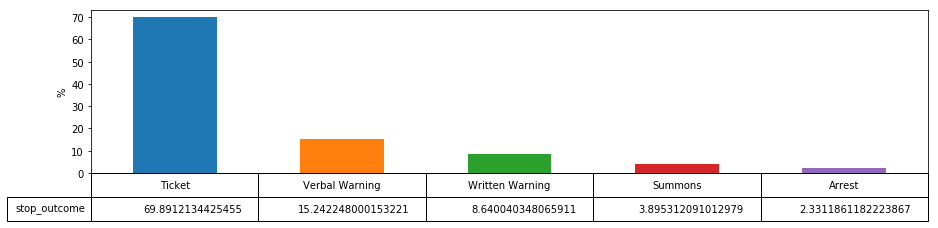

In [111]:
outcome_breakdown = df['stop_outcome'].value_counts(normalize=True).mul(100).plot.bar(figsize=(15, 3), table=True)
outcome_breakdown.axes.get_xaxis().set_visible(False)
outcome_breakdown.axes.set_ylabel('%')
outcome_breakdown.tables[0].scale(1, 2)

A vast majority of traffic stops result in the officer issuing a "`Ticket`" in 69.89% of the cases.  "`Arrest`"s comprise only 2.33% of traffic stops.  Some fortunate drivers are issued warnings, verbal and/or written, 23.9% of the time, while a few unfortunate drivers receive a "`Summon`"s to appear in court in 3.9% of traffic stops.  There is a high risk that a trained model using this dataset will have a strong bias towards predicting "Ticket" as the outcome if not handled properly.

#### Proportion of Searches Conducted Relative to All Stops

One interesting data point that CT officers collect is whether a search was conducted during the traffic stop, as captured in the **`search_conducted`** column.  When true, these traffic stops should correlate with a higher number of outcomes resulting in an "Arrest".

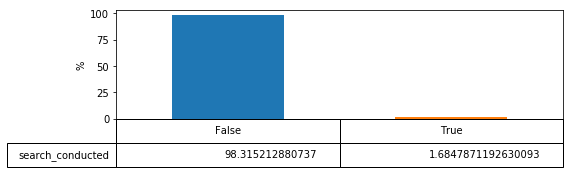

In [112]:
searches = df['search_conducted'].value_counts(normalize=True).mul(100).plot.bar(figsize=(8, 2), table=True)
searches.axes.get_xaxis().set_visible(False)
searches.axes.set_ylabel('%')
searches.tables[0].scale(1, 2)

#### Outcomes When Vehicle Searched

Indeed, the proportion of Arrests rises to 27.69% of traffic stops when a search is conducted.

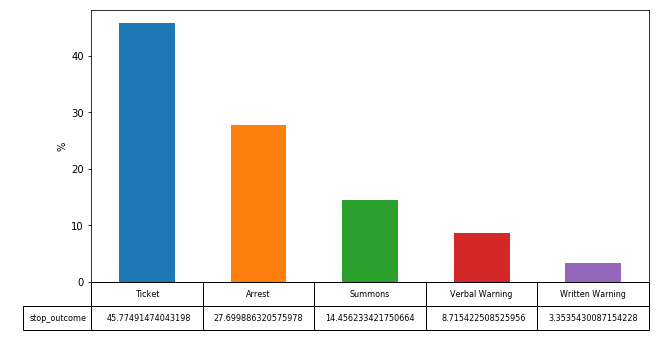

In [113]:
outcome_when_searched = df[df['search_conducted'] == True]['stop_outcome'].value_counts(normalize=True).mul(100).plot.bar(figsize=(10, 5), table=True)
outcome_when_searched.axes.get_xaxis().set_visible(False)
outcome_when_searched.axes.set_ylabel('%')
outcome_when_searched.tables[0].scale(1, 2)

Still, searches only comprise 1.7% of all traffic stops, so the fact remains that the data set is highly unbalanced.

#### Outcome by `stop_duration`

Another interesting data point is the duration of the traffic stop in the **`stop_duration`** column, which may provide another predictive signal about the likely outcome.  Logically speaking, the longer the duration of a traffic stop, the more likely the outcome will be an "Arrest", as the officer may need to ask more questions, search the vehicle, conduct a sobriety test, and perform other duties that take time and extend the duration of the traffic stop.  

In [114]:
# duration_outcomes = df.groupby(['stop_duration', 'stop_outcome'])
# duration_outcomes.agg({'id': 'count'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename(columns={'id': '%'})

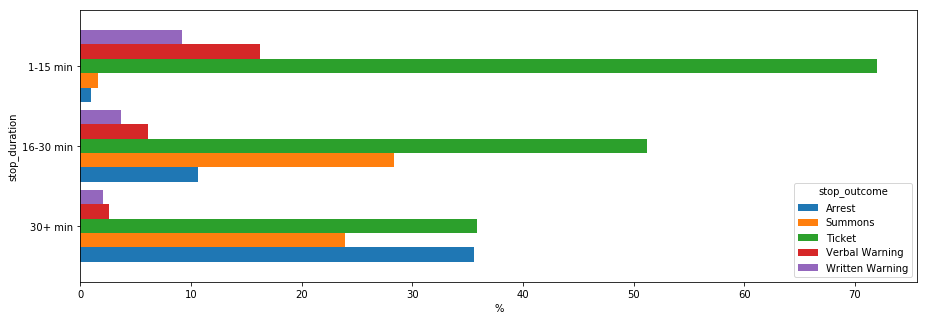

In [115]:
duration_dummies = pd.get_dummies(df.stop_duration)
outcomes_by_duration = pd.concat([df.stop_outcome, duration_dummies], axis=1)
outcomes_by_duration_grouped = outcomes_by_duration.groupby(['stop_outcome']).agg({x: 'sum' for x in duration_dummies.columns.values}).apply(lambda x: 100 * x / float(x.sum())).T
ax = outcomes_by_duration_grouped.plot.barh(figsize=(15, 5), width=0.9)
ax.set_xlabel('%')
ax.set_ylabel('stop_duration')

As suspected, the chances of a traffic stop resulting in an `Arrest`, as illustrated by the blue bars, is much higher when the stop lasts longer than 30 minutes at 35.64% than 1.01% when the stop lasts 15 minutes or less.

#### Race Breakdown

Another potential signal for the outcome of a traffic stop is race.



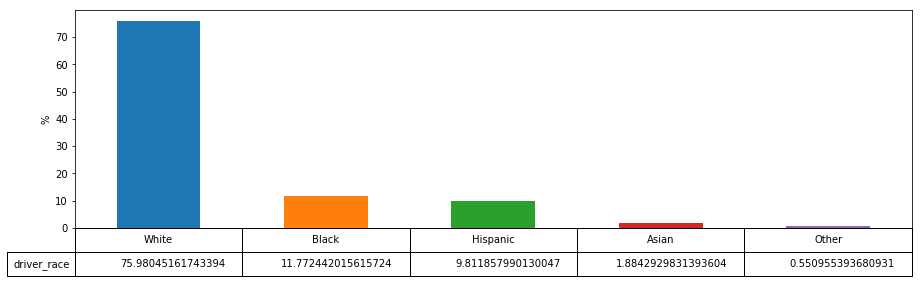

In [116]:
stops_by_race = df['driver_race'].value_counts(normalize=True).mul(100).plot.bar(figsize=(15, 4), table=True)
stops_by_race.axes.get_xaxis().set_visible(False)
stops_by_race.axes.set_ylabel('%')
stops_by_race.tables[0].scale(1, 2)

The dataset shows that the majority (76%) of traffic stops involved "`White`"s, with "`Black`"s at 11.75%, "`Hispanic`"s at 9.78%, "`Asian`"s at 1.87%, and a catch-all value of "`Other`" at 0.55%.  This approximately matches the 2010 census figures for Connecticut [**TODO**: reference?  https://www.census.gov/2010census/popmap/ipmtext.php?fl=09], where the racial composition is 77.57% "`White`", 10.14% "`Black`", 13.4% "`Hispanic`", 3.79% "`Asian`", and roughly 5.55% "`Other`".  For some reason, Hispanics are separated out by Ethnicity, so the numbers I provided have some overlap and sum to more than 100%.

![CT 2010 Census Data](./images/CT-2010-census-data.PNG)

One interesting note about the "Other" value is that in the **`driver_race_raw`** column of the dataset, this value was denoted as "Native American" and was subsequently replaced with "Other" in the **`driver_race`** column.

#### Arrests by Race by County

Looking for further insights, I thought it might be interesting to analyze racial breakdown of traffic stops by county.

In [117]:
# df.loc[df['stop_outcome'] == 'Arrest'].groupby(['county_name', 'driver_race']).agg({'id': 'count'}).groupby(level=0).apply(lambda x: 100 * x / float(x.sum())).rename(columns={'id': '%'})

In [118]:
arrested = df.loc[df['stop_outcome'] == 'Arrest']
arrested_dummies = pd.get_dummies(arrested.county_name)
arrested_races_by_county = pd.concat([arrested.driver_race, arrested_dummies], axis=1)
county_races = arrested_races_by_county.groupby(['driver_race']).agg({x: 'sum' for x in arrested_dummies.columns.values}).apply(lambda x: 100 * x /float(x.sum())).T
county_races

driver_race,Asian,Black,Hispanic,Other,White
New London County,1.277235,8.715252,9.541698,0.450789,80.015026
Hartford County,1.319797,23.553299,19.289340,0.507614,55.329949
Middlesex County,1.206897,12.586207,13.103448,0.000000,73.103448
New Haven County,0.922819,17.533557,22.315436,0.251678,58.976510
Litchfield County,1.140065,3.094463,10.097720,0.325733,85.342020
Windham County,0.698324,4.748603,17.318436,0.418994,76.815642
Fairfield County,1.007049,16.918429,28.700906,0.604230,52.769386
Tolland County,1.121076,7.735426,9.865471,0.112108,81.165919


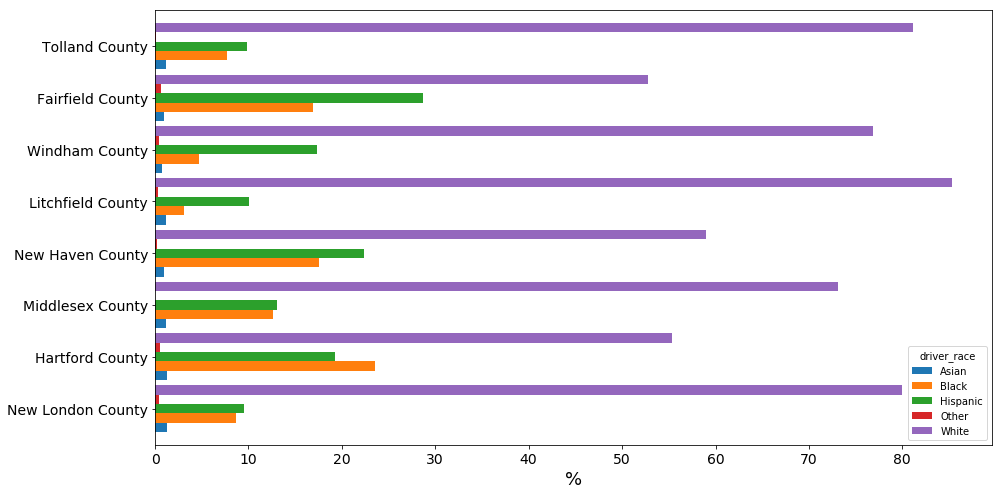

In [119]:
# # races_by_county
county_graph = county_races.plot.barh(figsize=(15, 8), width=0.9, fontsize=14)
county_graph.axes.set_xlabel('%', fontsize=18)

#[TODO: Specify the value unit here]

While the racial breakdown of traffic stops for the state overall are, for the most part, consistent with 2010 census data, these figures suggest that there are certain counties where Blacks and Hispanics are pulled over disproportionately higher than their composition in the 2010 census, namely in the Fairfield, Hartford, and New Haven counties.  This is not to suggest that they are being pulled over because of racial bias but is simply stated as an observation.

#### Traffic Stops by County

The distribution of traffic stops by county is moderately distributed.  Almost half of traffic stops occurred in New Haven, New London, and Tolland counties.

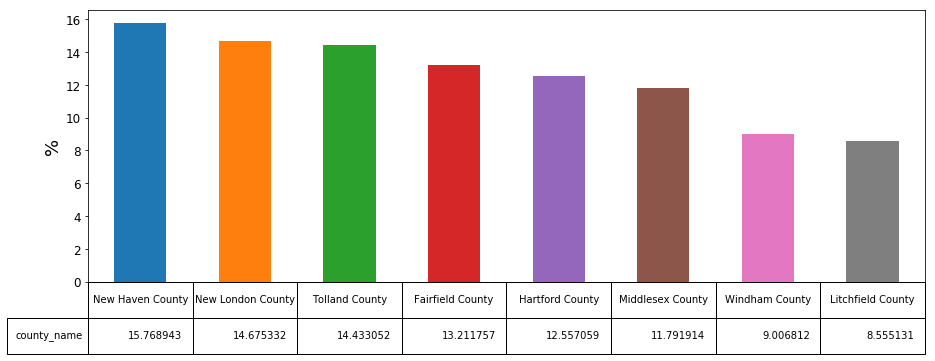

In [120]:
outcomes_by_county = df['county_name'].value_counts(normalize=True).mul(100).apply(lambda x: float('{:.6f}'.format(x))).plot.bar(figsize=(15, 5), table=True, fontsize=12)
outcomes_by_county.axes.get_xaxis().set_visible(False)
outcomes_by_county.axes.set_ylabel('%', fontsize=18)
outcomes_by_county.tables[0].auto_set_font_size(False)
outcomes_by_county.tables[0].set_fontsize(10)
outcomes_by_county.tables[0].scale(1, 3)

#### Outcomes by Violations

Two columns, **`violation`** and **`violations_raw`**, provide information about the related violation(s) involved in a traffic stop outcome.  Unfortunately, these columns suffer from repetitive values and inconsistent data entry issues.  For example, some values are phrased differently yet have the same meaning.  I will need to settle on a standard value for these duplicate values and perform one-hot encoding for each class value.

In [121]:
def normalize_violation(violation):
    """Normalize violation values
    """
    if violation == 'defective lights':
        return 'lights'
    elif violation == 'equipment violation':
        return 'equipment'
    elif violation == 'other/error':
        return 'other'
    elif violation == 'registration/plates':
        return 'registration'
    elif violation == 'seat belt':
        return 'seatbelt'
    elif violation == 'speed related':
        return 'speeding'
    elif violation == 'stop sign/light' or violation == 'stop sign':
        return 'bad_stop'
    return violation.replace(' ', '_')


def merge_violations(violations):
    """Merge violation and violation_raw columns
    """
    merged = []
    tokens = violations.lower().split(',')
    return list(set([normalize_violation(violation) for violation in tokens]))
    

def onehot_encode_violations(arr_violations):
    row = np.zeros(len(violations))
    for v in arr_violations:
        row[violations.index(v)] = 1
    return row


violations = []

for violation in list(df.violation.unique()) + list(df.violation_raw.unique()):
    tokens = violation.lower().split(',')
    violations.extend([normalize_violation(token) for token in tokens])

violations = sorted(set(violations))

merged = df[['violation_raw', 'violation']].apply(lambda x: ','.join(x), axis=1).apply(merge_violations)

violation_col_headers = ['violation_{}'.format(violation.replace(' ', '_')) for violation in violations]

df_violations = merged.apply(onehot_encode_violations).apply(lambda x: pd.Series(x, dtype=int))
df_violations.columns = violation_col_headers

The distribution of violation values shows that a majority of traffic stops involve speeding.

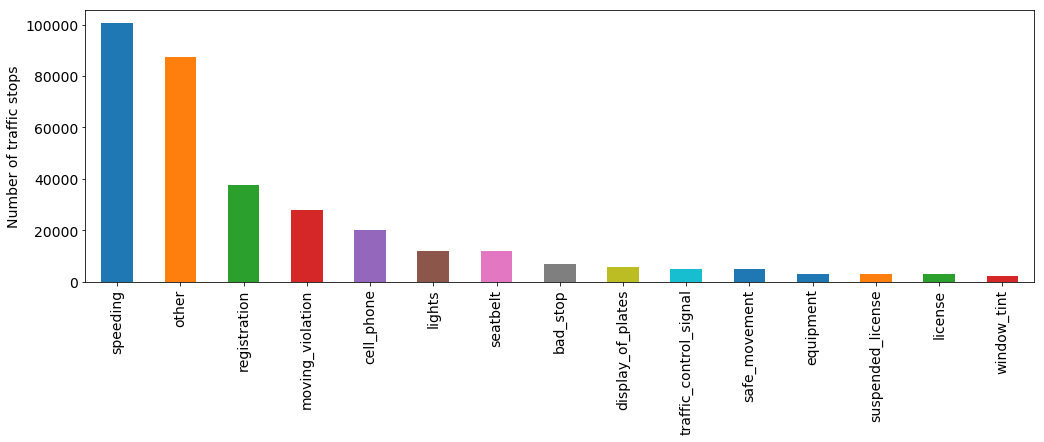

In [122]:
violations = df_violations.copy(deep=True)
violations.columns = [x.replace('violation_', '') for x in violations.columns.values]
violation_breakdown = violations.sum().sort_values(ascending=False).plot.bar(figsize=(17, 5), fontsize=14)
violation_breakdown.axes.set_ylabel('Number of traffic stops', fontsize=14)

The bar chart below shows the **outcome percentages** by violation type.

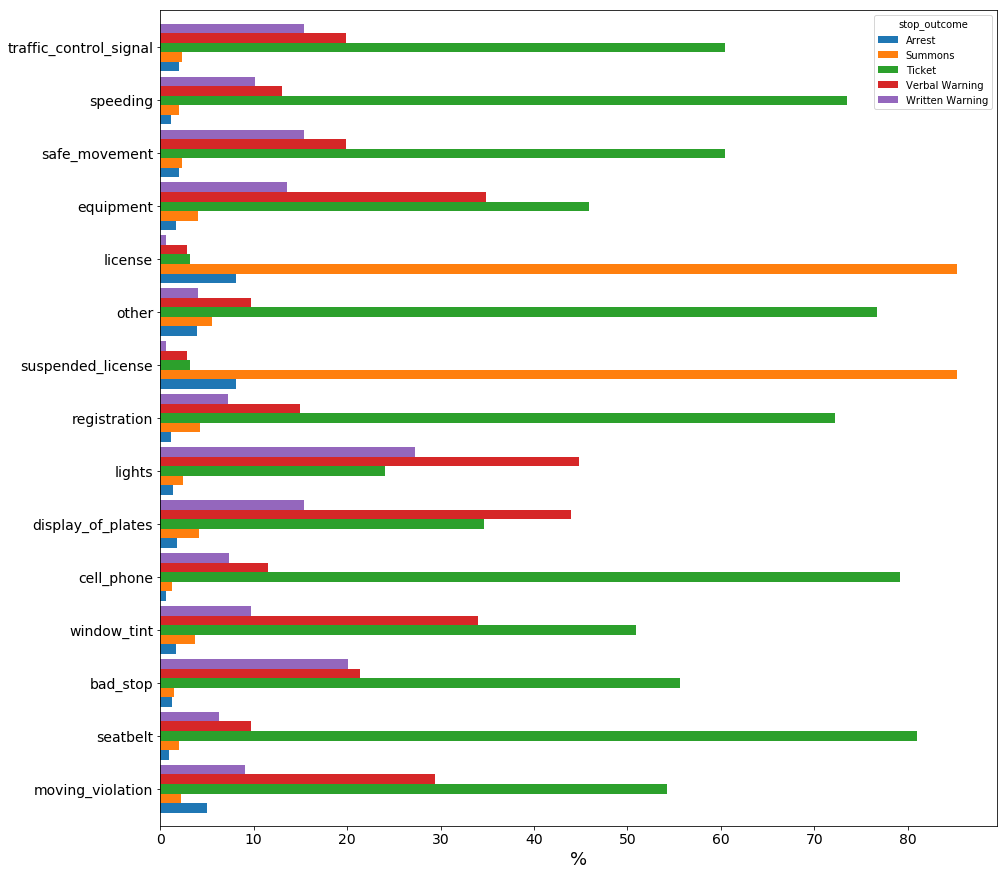

In [123]:
violation_outcomes = pd.concat([df.stop_outcome, df_violations], axis=1)

agg_dict = {}
outcomes_counts_by_violation = violation_outcomes.groupby(['stop_outcome']).agg({x: 'sum' for x in violation_col_headers}).apply(lambda x: 100 * x /float(x.sum())).rename(columns={x: x.replace('violation_','') for x in violation_col_headers}).T

outcomes_counts_by_violation_chart = outcomes_counts_by_violation.plot.barh(figsize=(15,15), width=0.9, fontsize=14)
outcomes_counts_by_violation_chart.axes.set_xlabel('%', fontsize=18)

Not surprisingly, most violations resulted in a "Ticket", but there are a few exceptions:
- Expired and suspended driver's licenses were more likely to result in a "Summons" to appear in court, as shown by the two elongated orange-colored bars.
- Improper display of license plates and non-functional lights were likely to result in a "Verbal Warning."

#### Gender Breakdown

Twice as many men got pulled over compared to women, as men comprised almost exactly two-thirds (66.5%) of this dataset.

In [124]:
# gender_vbar = df['driver_gender'].value_counts(normalize=True).mul(100).plot.bar(figsize=(8, 4), table=True)
# xaxis = gender_vbar.axes.get_xaxis()
# xaxis.set_visible(False)
# gender_vbar.axes.set_ylabel('%')
# table = gender_vbar.tables[0]
# table.scale(1, 2)

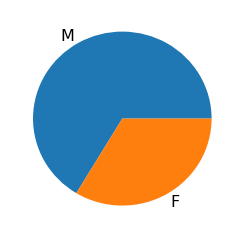

In [125]:
gender_vbar = df['driver_gender'].value_counts(normalize=True).mul(100).plot.pie(figsize=(4, 4), fontsize=16)
xaxis = gender_vbar.axes.get_xaxis()
xaxis.set_visible(False)
gender_vbar.axes.set_ylabel('')
# gender_vbar.axes.set_ylabel('%')
# table = gender_vbar.tables[0]
# table.scale(1, 2)

#### Age Breakdown

Those in their 20's have the highest percentage of traffic stops at 30.66%, with those in their 30's and 40's following suit, at 20.9% and 18.9% respectively.

In [126]:
# df['driver_age_raw'].describe()

# [TODO:  Remove or make a pretty table]

count    313274.000000
mean         38.066325
std          14.428419
min           0.000000
25%          26.000000
50%          35.000000
75%          49.000000
max          99.000000
Name: driver_age_raw, dtype: float64

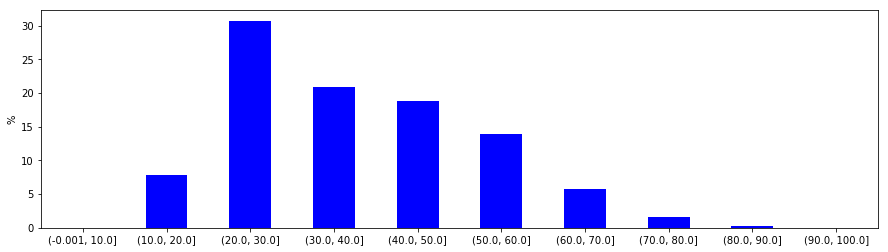

In [127]:
age_bins = pd.cut(df['driver_age_raw'], bins=[0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100], include_lowest=True)
ax = age_bins.value_counts(sort=False, normalize=True).mul(100).plot.bar(rot=0, color="b", figsize=(15,4))
ax.axes.set_ylabel('%')

274 records specify ages that are less than 15 years old, which appear to be typos and will be removed in the pre-processing stage.

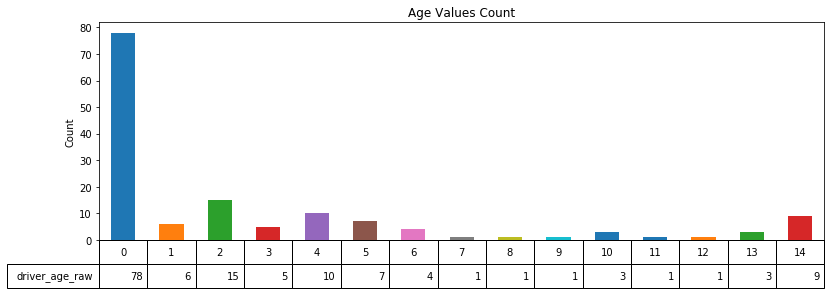

In [128]:
weird_ages_rows = df[df["driver_age_raw"] < 15]['driver_age_raw']
weird_ages = weird_ages_rows.value_counts(sort=False).plot.bar(figsize=(13, 4), table=True, title='Age Values Count')
xaxis = weird_ages.axes.get_xaxis()
xaxis.set_visible(False)
weird_ages.axes.set_ylabel('Count')
table = weird_ages.tables[0]
table.scale(1, 2)

### Algorithms and Techniques
In this section, you will need to discuss the algorithms and techniques you intend to use for solving the problem. You should justify the use of each one based on the characteristics of the problem and the problem domain. Questions to ask yourself when writing this section:
- _Are the algorithms you will use, including any default variables/parameters in the project clearly defined?_
- _Are the techniques to be used thoroughly discussed and justified?_
- _Is it made clear how the input data or datasets will be handled by the algorithms and techniques chosen?_

<!--
To solve this problem, I will experiment with three algorithms:
1. The VotingClassifier from the scikit-learn library
1. GradientBoostingClassifier also  from the scikit-learn library
1. XGBoost from the Distributed(Deep) Machine Learning Community (DMLC) at https://github.com/dmlc/xgboost.
-->

To create my classifier, I will first use **`sklearn.ensemble.VotingClassifier`** to identify a scikit-learn classifier that is suitable to fit my dataset.  The **`sklearn.ensemble.VotingClassifier`**, which combines different chosen classifiers to predict class labels.  I will use "soft voting" which takes the weighted average predicted probabilities of the underlying classifiers to predict a class label.  Here are the classifiers I will use along with their scikit-learn descriptions:

<table width=90%>
<thead>
<tr>
    <th style="text-align: center;">Classifier</th>
    <th style="text-align: center;">Description</th>
</tr>
</thead>
<tbody>
<tr>
    <td style="vertical-align:top">**RandomForestClassifier**</td>
    <td>
        Meta estimator that fits a number of decision tree classifiers on dataset sub-samples, using averages to improve predictive accuracy and minimize over-fitting.
    </td>
</tr>
<tr>
    <td style="vertical-align:top">**GaussianNB**</td>
    <td>Implements the Gaussian Naive Bayes algorithm</td>
</tr>
<tr>
    <td style="vertical-align:top">**DecisionTreeClassifier**</td>
    <td>Non-parametric learning method that predicts the value of a target variable by learning simple decision rules inferred from data features.</td>
</tr>
<tr>
    <td style="vertical-align:top">**GradientBoostingClassifier**</td>
    <td>
        Builds an additive model in a forward stage-wise fashion, allowing for the optimization of random differentiable loss functions.
    </td>
</tr>
</tbody>
</table>


For the most part, I used the default parameters for each classifier, with the exception of the **`n_jobs`**, **`verbose`**, and **`random_state`** parameters where available, which are specified as follows:

<table>
    <thead>
        <tr>
            <th></th>
            <th colspan=4 style="text-align: center;">Classifier</th>
        </tr>
        <tr>
            <th style="text-align: center;">Parameter</th>
            <th style="text-align: center;">GaussianNB</th>
            <th style="text-align: center;">RandomForestClassifier</th>
            <th style="text-align: center;">DecisionTreeClassifier</th>
            <th class="s2 softmerge">GradientBoostingClassifier</th>
        </tr>
    </thead>
    <tbody>
        <tr>
            <td style="font-weight: bold;">bootstrap</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">True</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
        </tr>
        <tr>
            <td style="font-weight: bold;">class_weight</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;"></td>
        </tr>
        <tr>
            <td style="font-weight: bold;">criterion</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">gini</td>
            <td style="text-align: center;">gini</td>
            <td style="text-align: center;">friedman_mse</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">init</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">None</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">learning_rate</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">0.1</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">loss</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">deviance</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">max_depth</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;">3</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">max_features</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">auto</td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;">None</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">max_leaf_nodes</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;">None</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">min_impurity_split</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">0.0000001</td>
            <td style="text-align: center;">0.0000001</td>
            <td style="text-align: center;">0.0000001</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">min_samples_leaf</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">1</td>
            <td style="text-align: center;">1</td>
            <td style="text-align: center;">1</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">min_samples_split</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">2</td>
            <td style="text-align: center;">2</td>
            <td style="text-align: center;">2</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">min_weight_fraction_leaf</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">0</td>
            <td style="text-align: center;">0</td>
            <td style="text-align: center;">0</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">n_estimators</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">10</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">100</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">n_jobs</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center; font-weight: bold;">8</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
        </tr>
        <tr>
            <td style="font-weight: bold;">oob_score</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">False</td>
            <td style="text-align: center;">best</td>
            <td style="text-align: center;"></td>
        </tr>
        <tr>
            <td style="font-weight: bold;">presort</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">False</td>
            <td style="text-align: center;">auto</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">priors</td>
            <td style="text-align: center;">None</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
        </tr>
        <tr>
            <td style="font-weight: bold;">random_state</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center; font-weight: bold;">0</td>
            <td style="text-align: center; font-weight: bold;">0</td>
            <td style="text-align: center; font-weight: bold;">0</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">splitter</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">best</td>
            <td style="text-align: center;"></td>
        </tr>
        <tr>
            <td style="font-weight: bold;">subsample</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">1</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">verbose</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center; font-weight: bold;">3</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center; font-weight: bold;">3</td>
        </tr>
        <tr>
            <td style="font-weight: bold;">warm_start</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">False</td>
            <td style="text-align: center;"></td>
            <td style="text-align: center;">False</td>
        </tr>
    </tbody>
</table>

I may need to manipulate my dataset until a desired accuracy score is reached.  At that point, I will select the most accurate classifier and conduct a grid search to tune its hyperparameters.

Finally, I hope to take advantage of my NVIDIA<sup>&reg;</sup> GeForce<sup>&reg;</sup> GTX 1080Ti GPU by using the **`XGBoost`** classifier.  Short for "e**X**treme **G**radient **Boost**ing," XGBoost is an optimized distributed gradient boosting library that implements machine learning algorithms under the Gradient Boosting framework and supports NVIDIA<sup>&reg;</sup> GPU's.  It has been used in many winning Kaggle competition solutions ([TODO: Add reference to https://github.com/dmlc/xgboost/tree/master/demo#machine-learning-challenge-winning-solutions).

### Benchmark
In this section, you will need to provide a clearly defined benchmark result or threshold for comparing across performances obtained by your solution. The reasoning behind the benchmark (in the case where it is not an established result) should be discussed. Questions to ask yourself when writing this section:
- _Has some result or value been provided that acts as a benchmark for measuring performance?_
- _Is it clear how this result or value was obtained (whether by data or by hypothesis)?_

As far as I know, there is no external benchmark to assess the accuracy of a traffic stop outcome prediction.  From my analysis of the data, generating a naive predictor would be appropriate to set a benchmark.  The most common **`stop_outcome`** value in this dataset is "Ticket" which comprises 70% of all outcomes as described in the following table:

| Outcome         | Count   |    %   |
|:----------------|--------:|-------:|
|Arrest           |   7,312 |  2.33% |
|Summons          |  12,205 |  3.90% |
|Ticket           | 218,973 | 69.89% |
|Verbal Warning	  |  47,753 | 15.24% |
|Written Warning  |  27,070 |  8.64% |
|                 | 313,313 |        |

As a base model without any intelligence, predicting every traffic stop outcome to be "Ticket" will generate an accuracy score of around 0.70 and serve as the benchmark model.



## III. Methodology
_(approx. 3-5 pages)_

### Data Preprocessing
In this section, all of your preprocessing steps will need to be clearly documented, if any were necessary. From the previous section, any of the abnormalities or characteristics that you identified about the dataset will be addressed and corrected here. Questions to ask yourself when writing this section:
- _If the algorithms chosen require preprocessing steps like feature selection or feature transformations, have they been properly documented?_
- _Based on the **Data Exploration** section, if there were abnormalities or characteristics that needed to be addressed, have they been properly corrected?_
- _If no preprocessing is needed, has it been made clear why?_


[TODO: Elaborate on these]
Steps:
1. Remove records with age less than 15
1. Normalize violations [Actually done above]
1. Fill in empty **`stop_time`** with median value
1. Categorize overly granular field values
1. One-hot encode other categorical feature values
1. Drop duplicate rows
1. Oversample?

I took the following preprocessing steps prior to using the dataset for model training:

1. Dropped the data columns that were unnecessary, namely:  **`county_fips`**, **`driver_age`**, **`driver_race_raw`**, **`fine_grained_location`**, **`id`**, **`is_arrested`**, **`officer_id`**, **`police_department`**, **`search_type_raw`**, **`search_type`**, **`state`**.
1. Removed rows where **`stop_outcome`** and **`county_name`** had empty values, as well as rows which had **`driver_age_raw`** values below 15.
1. Normalized the violations data by combining values from the **`violation`** and **`violation_raw`** columns, merging similar values into a common value, then manually one-hot encoded the values into their own binary columns, which were then appended to the main dataframe as additional features.
1. Calculated the median traffic stop time and used it to fill in the null values for the **`stop_time`** field.
1. Categorized time-specific **`stop_time`** values into period-of-day values into a new **`day_period`** column: morning, afternoon, evening, small hours.
1. Categorized date-specific **`stop_date`** values into annual season values into a new **`season`** column: Spring, Summer, Fall, and Winter.
1. Converted **`driver_gender`** values into binary values into a new **`is_male`** column.
1. Dropped no longer needed columns:  **`driver_gender`**, **`stop_date`**, **`stop_time`**, **`violation_raw`**, **`violation`**.
1. Converted **`search_conducted`** and **`contraband_found`** columns to binary values in-place.
1. Normalized **`driver_age`** values to values between 0.0 and 1.0 using **`sklearn.preprocessing.MinMaxScaler`** in-place.
1. Performed one-hot encoding using for the following fields:  **`county_name`**, **`driver_race`**, **`stop_duration`**, **`day_period`**, **`season`**



In [129]:
# Append one-hot encoded violations
df = pd.concat([df, df_violations], axis=1)

# Remove records with age less than 15
df.drop(index=weird_ages_rows.index, inplace=True)

# Fill in empty **`stop_time`** with median value
populated = df[df.stop_time.notnull()]['stop_time'].sort_values()
median_stop_time = populated.iloc[populated.shape[0] // 2]
df['stop_time'].fillna(median_stop_time, inplace=True)

In [130]:
# df.shape

(313129, 28)

In [131]:
# Categorize stop_time into time-of-day: "morning, afternoon, evening, small hours"
def day_period(time_str):
    hour = time_str.hour
    if hour >= 0 and hour < 6:
        return 'Small Hours'
    elif hour >= 6 and hour < 12:
        return 'Morning'
    elif hour >= 12 and hour < 18:
        return 'Afternoon'
    else:
        return 'Evening'

df['day_period'] = pd.to_datetime(df['stop_time']).apply(day_period)


In [132]:
# df.shape

(313129, 29)

In [133]:
# Categorize stop_date by season
def season(stop_date):
    month = datetime.strptime(stop_date, '%Y-%m-%d').month
    if month >= 3 and month < 6:
        return 'Spring'
    elif month >= 6 and month < 9:
        return 'Summer'
    elif month >= 9 and month < 12:
        return 'Fall'
    return 'Winter'

df['season'] = df['stop_date'].apply(season)

In [134]:
# Transform driver_gender to binary
df['is_male'] = df['driver_gender'].apply(lambda x: 1 if x == 'M' else 0)

In [135]:
# Experiment: See whether labelencoding location_raw improves performance
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df['location_raw'] = le.fit_transform(df['location_raw'])

In [136]:
# df.shape

(313129, 31)

In [137]:
# Drop columns no longer needed due to normalization
drop_cols = [
    'driver_gender',
#     'county_name',
#     'location_raw',
#     'officer_id',
    'stop_date',
    'stop_time',
    'violation_raw',
    'violation',
]

df.drop(drop_cols, axis=1, inplace=True)

In [138]:
# df.shape

(313129, 26)

In [139]:
# Convert booleans to 0 and 1
df['search_conducted'] = df['search_conducted'].apply(lambda x: int(x))
df['contraband_found'] = df['contraband_found'].apply(lambda x: int(x))

In [ ]:
# Normalize driver_age
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler() # default=(0, 1)
features_transformed = pd.DataFrame(data=df)
features_transformed['driver_age_raw'] = scaler.fit_transform(features_transformed['driver_age_raw'].reshape(-1, 1))
# features_transformed

In [141]:
features_transformed.shape

(313129, 26)

In [142]:
features_transformed.drop_duplicates(inplace=True)

In [143]:
# features_transformed.shape

(277733, 26)

In [144]:
# Prefix officer id numbers as dtype is object and get_dummies() creates some duplicate columns
# features_transformed['officer_id'] = le.fit_transform(features_transformed['officer_id'].apply(lambda x: 'no_{}'.format(x)))


In [145]:
# One-hot encode categorical variables
cols_to_encode = [
#     'location_raw',
    'county_name',
    'driver_race',
#     'officer_id',
    'stop_duration',
    'day_period',
    'season',
]
final_features = pd.get_dummies(features_transformed, columns=cols_to_encode)
# final_features.columns.values

array(['location_raw', 'driver_age_raw', 'search_conducted',
       'contraband_found', 'stop_outcome', 'violation_bad_stop',
       'violation_cell_phone', 'violation_display_of_plates',
       'violation_equipment', 'violation_license', 'violation_lights',
       'violation_moving_violation', 'violation_other',
       'violation_registration', 'violation_safe_movement',
       'violation_seatbelt', 'violation_speeding',
       'violation_suspended_license', 'violation_traffic_control_signal',
       'violation_window_tint', 'is_male', 'county_name_Fairfield County',
       'county_name_Hartford County', 'county_name_Litchfield County',
       'county_name_Middlesex County', 'county_name_New Haven County',
       'county_name_New London County', 'county_name_Tolland County',
       'county_name_Windham County', 'driver_race_Asian',
       'driver_race_Black', 'driver_race_Hispanic', 'driver_race_Other',
       'driver_race_White', 'stop_duration_1-15 min',
       'stop_duration_16-30 

In [146]:
# final_features.shape

(277733, 45)

In [164]:
from datetime import datetime

timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

non_oversampled = final_features.copy(deep=True)
non_oversampled_outcomes = non_oversampled.pop('stop_outcome')

# non_oversampled.to_pickle('./final_features-{}-non_oversampled.pkl'.format(timestamp))
# non_oversampled_outcomes.to_pickle('./labels-{}-non_oversampled.pkl'.format(timestamp))
# print('timestamp = {}'.format(timestamp))

An additional preprocessing step I took was oversampling the data to address the extreme imbalance in the traffic stop outcomes.  I computed a multiplier for each non-"Ticket" outcome value:

In [148]:
tickets = final_features.loc[final_features['stop_outcome'] == 'Ticket']
arrests = final_features.loc[final_features['stop_outcome'] == 'Arrest']
summons = final_features.loc[final_features['stop_outcome'] == 'Summons']
ww = final_features.loc[final_features['stop_outcome'] == 'Written Warning']
vw = final_features.loc[final_features['stop_outcome'] == 'Verbal Warning']

In [ ]:
multiplier_arrests = tickets.shape[0] // arrests.shape[0]
multiplier_summons = tickets.shape[0] // summons.shape[0]
multiplier_ww = tickets.shape[0] // ww.shape[0]
multiplier_vw = tickets.shape[0] // vw.shape[0]
# print('Arrests: {}\nSummons: {}\nWW: {}\nVW: {}'.format(multiplier_arrests, multiplier_summons, multiplier_ww, multiplier_vw))
# Output:
# Arrests: 26
# Summons: 15
# WW: 7
# VW: 4


| Outcome         | Multiplier |
|:----------------|:----------:|
| Arrest          |     26     |
| Summons         |     15     |
| Written Warning |      7     |
| Verbal Warning  |      4     |

In [150]:
oversampled = final_features.append([arrests] * multiplier_arrests, ignore_index=True)
oversampled = oversampled.append([summons] * multiplier_summons, ignore_index=True)
oversampled = oversampled.append([ww] * multiplier_ww, ignore_index=True)
oversampled = oversampled.append([vw] * multiplier_vw, ignore_index=True)
# oversampled.shape

(1009048, 45)

In [151]:
# Extract target labels
outcomes = oversampled.pop('stop_outcome')

I then replicated the associated rows by their multipliers, and the more balanced resulting distribution of outcomes is illustrated in the following bar chart:

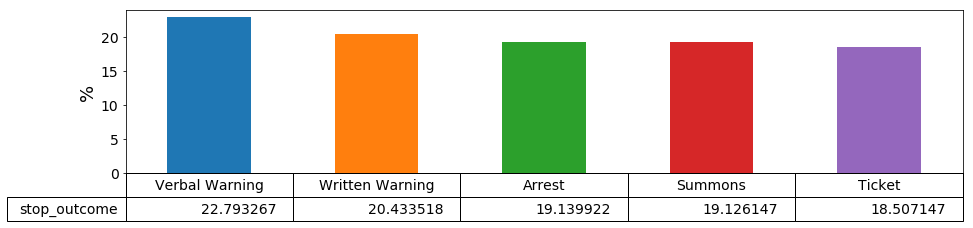

In [163]:
outcome_breakdown = outcomes.value_counts(normalize=True).mul(100).apply(lambda x: float('{:.6f}'.format(x))).plot.bar(figsize=(15, 3), table=True, fontsize=14)
outcome_breakdown.axes.get_xaxis().set_visible(False)
outcome_breakdown.axes.set_ylabel('%', fontsize=18)
outcome_breakdown.tables[0].auto_set_font_size(False)
outcome_breakdown.tables[0].set_fontsize(14)
outcome_breakdown.tables[0].scale(1, 2)

In [153]:
# oversampled.shape

(1009048, 44)

In [154]:
# from datetime import datetime

# timestamp = datetime.now().strftime('%Y%m%d%H%M%S')

# oversampled.to_pickle('./final_features-{}.pkl'.format(timestamp))
# outcomes.to_pickle('./labels-{}.pkl'.format(timestamp))
# print('timestamp = {}'.format(timestamp))

timestamp = 20180513145629


For the final step of preprocessing, **XGBoost** requires the input data to be transformed into an internal data structure that XGBoost uses to optimize for both memory efficiency and training speed.  Once the dataset was split between training and testing sets, I created instances of the **`xgboost.DMatrix`** class, which were used as input data to the **`xgboost.train()`** function.

### Implementation
In this section, the process for which metrics, algorithms, and techniques that you implemented for the given data will need to be clearly documented. It should be abundantly clear how the implementation was carried out, and discussion should be made regarding any complications that occurred during this process. Questions to ask yourself when writing this section:
- _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_
- _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_
- _Was there any part of the coding process (e.g., writing complicated functions) that should be documented?_

#### _Is it made clear how the algorithms and techniques were implemented with the given datasets or input data?_

For the **`sklearn.linear_model.SGDClassifier`**, untuned, this classifier produced an abysmal score of **`0.3173951596077613`** or **31.74% accuracy**.

In my preliminary testing with the following classifiers, I kept hitting a ceiling of 82% prediction accuracy no matter how many runs I set or parameters I tweaked.  So, I decided to add the **`location_raw`** data back into the training data, and the accuracy improved significantly.  The results that follow reflect the addition of this data column.

The **VotingClassifier** resulted in a score of **`0.9195076152722721`**, considerably more accurate than the SGDClassifier.  I was pleaantly surprised by this result, not expecting to achieve this level of accuracy with no parameter tuning.  Curious, I fitted each classifier independently, again with just the default parameters, and generated the following results:

| Classifier                  | Accuracy Score | Training Time  |
|:----------------------------|:--------------:|:--------------:|
| RandomForestClassifier      |      0.9140    |      9.55 secs |
| GaussianNB                  |      0.4560    |     0.959 secs |
| DecisionTreeClassifier      |      0.9102    |      4.43 secs |
| GradientBoostingClassifier  |      0.5133    |  7 min 13 secs |

Next, with minimal parameters set, **XGBoost** achieved **0.114328 error**, equating to **88.57% accuracy**. This result was achieved after 9,006 runs where the **`early_stopping_rounds`** parameter was set to 50.  To clarify, I set the number of rounds to 10,000, but the model would stop training once the current run generated an error that was no lower than the lowest eror over the previous 50 runs.  Please note that I am using [training] run and round synonymously.  An interesting issue I encounted was that the browser I was using for the Jupyter notebook to code this run kept crashing once the training session got past 3,300+ runs, so I had to move the code to a Python script and execute it from the command line.  Based on my recollection, the training time took around an hour and a half to achieve this score.


#### _Were there any complications with the original metrics or techniques that required changing prior to acquiring a solution?_

- XGBoost's API enables you to create and train a model through a method or a class:  xgb.train or XGBClassifier.  The latter can be used with **`sklearn.model_selection.GridSearchCV`** to perform a grid search.  Unfortunately, I was not able to get it to work with my GPU, so I implemented a manual grid search in which I experimented with various values for 3 parameter variables [TODO: list the variables] until minimum error was achieved using sample sets of 10,000 rows.

#### Was there any part of the coding process (e.g., writing complicated functions) that should be documented?

### Refinement
In this section, you will need to discuss the process of improvement you made upon the algorithms and techniques you used in your implementation. For example, adjusting parameters for certain models to acquire improved solutions would fall under the refinement category. Your initial and final solutions should be reported, as well as any significant intermediate results as necessary. Questions to ask yourself when writing this section:
- _Has an initial solution been found and clearly reported?_
- _Is the process of improvement clearly documented, such as what techniques were used?_
- _Are intermediate and final solutions clearly reported as the process is improved?_

#### _Has an initial solution been found and clearly reported?_

#### _Is the process of improvement clearly documented, such as what techniques were used?_

As mentioned earlier, I added the **`location_raw`** column back into the training data after my preliminary training runs reached an accuracy limit.  To add this data column back, I tried one-hot encoding it, but doing so added 184 feature columns, one for each unique value.  This resulted in out-of-memory errors while training a model and was not a feasible option.  To overcome this, I used **`sklearn.preprocessing.LabelEncoder`** which transforms each unique value into an integer value which could be transformed back into its string label value later on.  The added benefit is that only one feature column slot is used.

Next, I focused on tuning XGBoost's parameters to leverage my GPU and perform more experiments with different parameters in a shorter period of time than with just a CPU.  I attempted to implement a grid search using **`sklearn.model_selection.GridSearchCV`**.  Unfortunately, I was not able to leverage my GPU to do this using XGBoost's **`XGBClassifier`** class.  Even though there were no errors while fitting this model, I monitored GPU activity with NVIDIA's **`nvidia-smi`** utility and saw that the GPU was not being used.

Instead, to leverage the GPU, I mimicked a grid search by using the **`xgb.train()`** function with the **`tree_method`** parameter set to "gpu_hist", iterating through different values for various parameters through nested Python for-loops and a data sample of 10,000 rows.  The optimal set of parameters I found for XGBoost were the following:

| Parameter | Value |
|-----------|:-----:|
| objective | multi:softmax |
| learning_rate | 0.0983 |
| max_depth | 19 |
| silent | 0 |
| nthread | 8 |
| tree_method | gpu_hist |
| subsample | 0.9 |
| num_class | 44 |

#### _Are intermediate and final solutions clearly reported as the process is improved?_

I set the **`num_boost_rounds`** to "10000" and **`early_stopping_rounds`** to "50", so that the classifier would attempt no more than 10,000 runs and would stop fitting once the error was higher than the lowest error over the previous 50 runs.  With these parameters, XGBoost achieved an error of **0.061229918631337366** or **93.88% accuracy** over 597 runs in 1 hour and 3 minutes.  The result is somewhat disappointing as it only represents a **2.48% improvement** over the best CPU-bound classifier, RandomForestClassifier, which achieved 91.4% accuracy in 9.55 seconds.


Results after adding back **`location_raw`**:

| Classifier                  | Accuracy Score | Training Time  |
|:----------------------------|:--------------:|:--------------:|
| RandomForestClassifier      |      0.9264    |     5.10 secs  |
| GaussianNB                  |      0.3754    |     1.54 secs  |
| DecisionTreeClassifier      |      0.9190    |     1.13 secs  |
| GradientBoostingClassifier  |      0.    |  7 min 13 secs |


Using RandomizedSearchCV with RandomForestClassifier and the following parameters:
    'n_estimators': [10, 100],
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 19],
    'max_features': [None, 'sqrt', 'log2'],
    'n_jobs': [8],
    'random_state': [0],
    'verbose': [3],

...determined that optimal params are:
verbose=3
random_state=0
n_jobs=8
n_estimators=<n_estimators>
max_features="sqrt"
max_depth=None
criterion="entropy"

Did further tuning with n_estimators and got following performance:

    n_estimators=50   # 0.9301481326935114   18.5 s
    n_estimators=100  # 0.9306175672856248   35.7 s
    n_estimators=200  # 0.930732317963697
    n_estimators=450  # 0.9310922178176507
    n_estimators=675  # 0.9312121844356352  # 3 mins

    n_estimators=1 0   # 0.9288092760517318     4.61s
    n_estimators=100   # 0.9321787820226947       39s
    n_estimators=450   # 0.9322828402953273    2m 26s
    n_estimators=675   # 0.9322283335810911    8m  2s



## IV. Results
_(approx. 2-3 pages)_

### Model Evaluation and Validation
In this section, the final model and any supporting qualities should be evaluated in detail. It should be clear how the final model was derived and why this model was chosen. In addition, some type of analysis should be used to validate the robustness of this model and its solution, such as manipulating the input data or environment to see how the model’s solution is affected (this is called sensitivity analysis). Questions to ask yourself when writing this section:
- _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_
- _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_
- _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_
- _Can results found from the model be trusted?_

#### _Is the final model reasonable and aligning with solution expectations? Are the final parameters of the model appropriate?_

#### _Has the final model been tested with various inputs to evaluate whether the model generalizes well to unseen data?_

The final model I chose was the XGBoost classifier with the parameters specified in the previous section.  Even though it took **`RandomForestClassifier`** and **`DecisionTreeClassifier`** mere seconds to achieve accuracy scores there were only ~2.5% lower, XGBoost still had the highest accuracy.

To ensure that I could be confident of my classifier, I sliced 5% of the dataset, before feeding the dataset through **`sklearn.model_selection.train_test_split`**, for the purpose of adding a second testing set that was not involved in the training process at all.  Testing model predictions with this dataset was consistent, usually within 1/10000th of the error from the test set generated by **`train_test_split`**.

#### _Is the model robust enough for the problem? Do small perturbations (changes) in training data or the input space greatly affect the results?_

#### _Can results found from the model be trusted?_


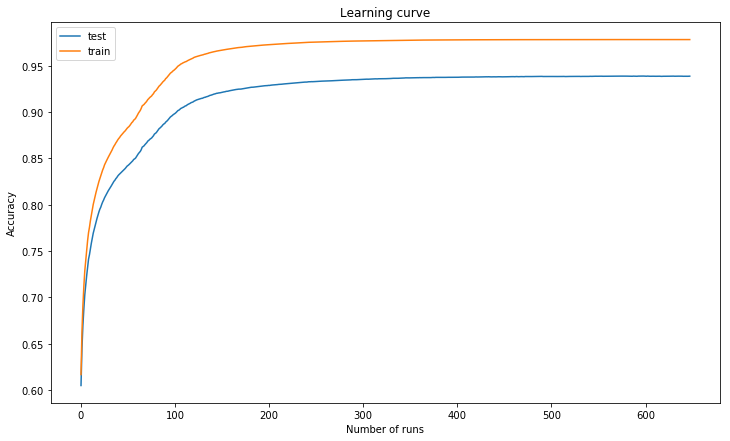

In [95]:
# Plot training and testing results

logfile = 'runs/201805111748-oversampled-647-run.log'

error_results = {
    'train': [],
    'test': [],
}

with open(logfile, 'r') as f:
    for line in f:
        tokens = line.strip().split('\t')
        error_results['train'].append(float(tokens[1].split(':')[1]))
        error_results['test'].append(float(tokens[2].split(':')[1]))

df_errors = pd.DataFrame(error_results)
df_accuracy = df_errors.copy()
df_accuracy_processed = df_accuracy.mul(-1).add(1)

learning_curve = df_accuracy_processed.plot.line(title='Learning curve', figsize=(12,7))
learning_curve.set_xlabel('Number of runs')
learning_curve.set_ylabel('Accuracy')


### Justification
In this section, your model’s final solution and its results should be compared to the benchmark you established earlier in the project using some type of statistical analysis. You should also justify whether these results and the solution are significant enough to have solved the problem posed in the project. Questions to ask yourself when writing this section:
- _Are the final results found stronger than the benchmark result reported earlier?_
- _Have you thoroughly analyzed and discussed the final solution?_
- _Is the final solution significant enough to have solved the problem?_

#### _Are the final results found stronger than the benchmark result reported earlier?_



#### _Have you thoroughly analyzed and discussed the final solution?_

#### _Is the final solution significant enough to have solved the problem?_

## V. Conclusion
_(approx. 1-2 pages)_

### Free-Form Visualization
In this section, you will need to provide some form of visualization that emphasizes an important quality about the project. It is much more free-form, but should reasonably support a significant result or characteristic about the problem that you want to discuss. Questions to ask yourself when writing this section:
- _Have you visualized a relevant or important quality about the problem, dataset, input data, or results?_
- _Is the visualization thoroughly analyzed and discussed?_
- _If a plot is provided, are the axes, title, and datum clearly defined?_

#### Have you visualized a relevant or important quality about the problem, dataset, input data, or results?

Here is a horizontal barchart of the sorted feature importances from the trained **`RandomForestClassifier`**:

![Model Feature Importance](images/rfc-feature_importance.png)

Not surpringly, **`location_raw`** is the most important as it is the only real numerical value.  


#### Is the visualization thoroughly analyzed and discussed?

#### If a plot is provided, are the axes, title, and datum clearly defined?

### Reflection
In this section, you will summarize the entire end-to-end problem solution and discuss one or two particular aspects of the project you found interesting or difficult. You are expected to reflect on the project as a whole to show that you have a firm understanding of the entire process employed in your work. Questions to ask yourself when writing this section:
- _Have you thoroughly summarized the entire process you used for this project?_
- _Were there any interesting aspects of the project?_
- _Were there any difficult aspects of the project?_
- _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_

#### _Have you thoroughly summarized the entire process you used for this project?_

#### _Were there any interesting aspects of the project?_

- Depending on the dataset, using a GPU isn't always necessary to get accurate results
- 

There were many interesting aspects of the project.  I experienced many moments of discovery as I experimented with data structures and tuned various hyperparameters.  For me, the most interesting aspect was seeing how big of an impact adding the **`location_raw`** field had on accuracy performance.  Prior to that, I kept hitting a ceiling of 82% accuracy no matter which algorithm I used or which hyperparameters I tuned.

**`location_raw`** had the second highest feature importance.  The field with the highest importance was **`driver_age`**.  It makes sense as it is the only truly numerical field in the dataset, even if it is more characteristic of a discrete label.


#### _Were there any difficult aspects of the project?_

Because XGBoost has been used in so many winning Kaggle competition solutions, I expected there to be more information available in forums and blog posts to resolve issues.  For some of the problems I encountered, the information was surprisingly sparse.

Of course, training time is always an issue.  I used my own hardware rig for training, and even with an Intel i7-7700K CPU (quad-core with 8 threads) with 16 GB RAM and an NVIDIA GTX 1080Ti GPU, it felt long and time-consuming for many experiments.  I am sure it would have felt even more tedious and prolonged had I only been able to use a CPU-only system.

Sufficient memory was a challenge when experimenting with inclusion of the **`officer_id`** field.


- Attempted to one-hot encode **`officer_id`** field that had 1200+ unique values, but ran into memory issues.  Tried to use **`sklearn.preprocessing.LabelEncoder`** function to reduce number of columns to one, but the number of values would have created too many trees, so also encountered out-of-memory errors.
- Similarly, one-hot encoding the **`location_raw`** field with 220+ unique values also encountered out-of-memory errors, but fortunately, **`sklearn.preprocessing.LabelEncoder`** function worked well, and helped increase accuracy significantly.


#### _Does the final model and solution fit your expectations for the problem, and should it be used in a general setting to solve these types of problems?_


### Improvement
In this section, you will need to provide discussion as to how one aspect of the implementation you designed could be improved. As an example, consider ways your implementation can be made more general, and what would need to be modified. You do not need to make this improvement, but the potential solutions resulting from these changes are considered and compared/contrasted to your current solution. Questions to ask yourself when writing this section:
- _Are there further improvements that could be made on the algorithms or techniques you used in this project?_
- _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_
- _If you used your final solution as the new benchmark, do you think an even better solution exists?_

#### _Are there further improvements that could be made on the algorithms or techniques you used in this project?_

It may be possible to increase accuracy by finding conducting further experiements to accommodate the **`officer_id`** field.  I suspect that increased hardware RAM might make it possible, but there is also the risk that any model created with such granular data might be more prone to overfitting.  Then again, incorporating this field might reveal and incorporate biases of certain officers into our model which might improve accuracy.

[TODO: REMOVE?] Perhaps, another way my classifier might be improved is to use logloss for my primary performance metric, as it provides a better measure of the quality of my model.  It punishes the model more severely when it is very confident in a prediction but is wrong.

#### _Were there algorithms or techniques you researched that you did not know how to implement, but would consider using if you knew how?_

As I experimented and researched solutions for problems I encountered while developing my model, I came across another boosting framework called, Light GBM, that, at least by one benchmark test by Analytics Vidya, may be slightly more accurate and significantly more performant (see "Which algorithm takes the crown: Light GBM vs XGBOOST?" at https://www.analyticsvidhya.com/blog/2017/06/which-algorithm-takes-the-crown-light-gbm-vs-xgboost/).  Light GBM splits its trees leaf-wise, instead of level-wise as XGBoost does.

#### - _If you used your final solution as the new benchmark, do you think an even better solution exists?_

My benchmark of 95% accuracy is quite high and may be difficult to improve.  Of course, there is always the possibility thtat an even better solution exists.  Further hyperparameter tuning might achieve this.  Plus, experiments with Light GBM or a convolutional neural network might also improve performance.

-----------

**Before submitting, ask yourself. . .**

- Does the project report you’ve written follow a well-organized structure similar to that of the project template?
- Is each section (particularly **Analysis** and **Methodology**) written in a clear, concise and specific fashion? Are there any ambiguous terms or phrases that need clarification?
- Would the intended audience of your project be able to understand your analysis, methods, and results?
- Have you properly proof-read your project report to assure there are minimal grammatical and spelling mistakes?
- Are all the resources used for this project correctly cited and referenced?
- Is the code that implements your solution easily readable and properly commented?
- Does the code execute without error and produce results similar to those reported?

## References

